Enter mini-batch size (default is 8):  8
Enter hidden activation function for first hidden layer (tanh, leaky_relu, logistic):  tanh
Enter hidden activation function for second hidden layer (tanh, leaky_relu, logistic):  tanh
Do you want to load pre-trained weights? (yes/no):  y


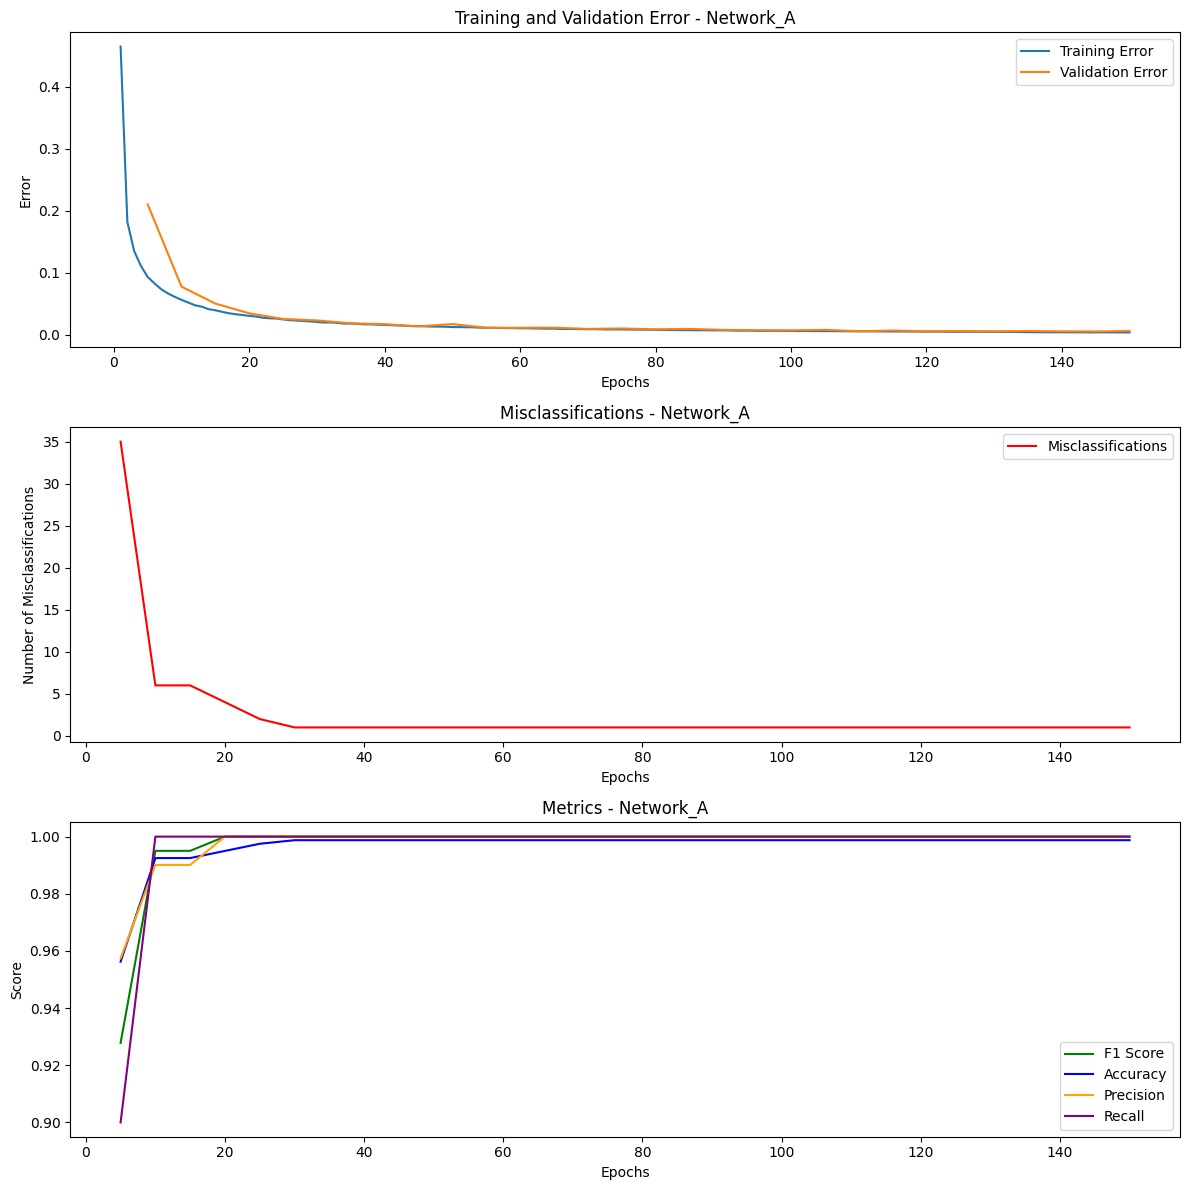

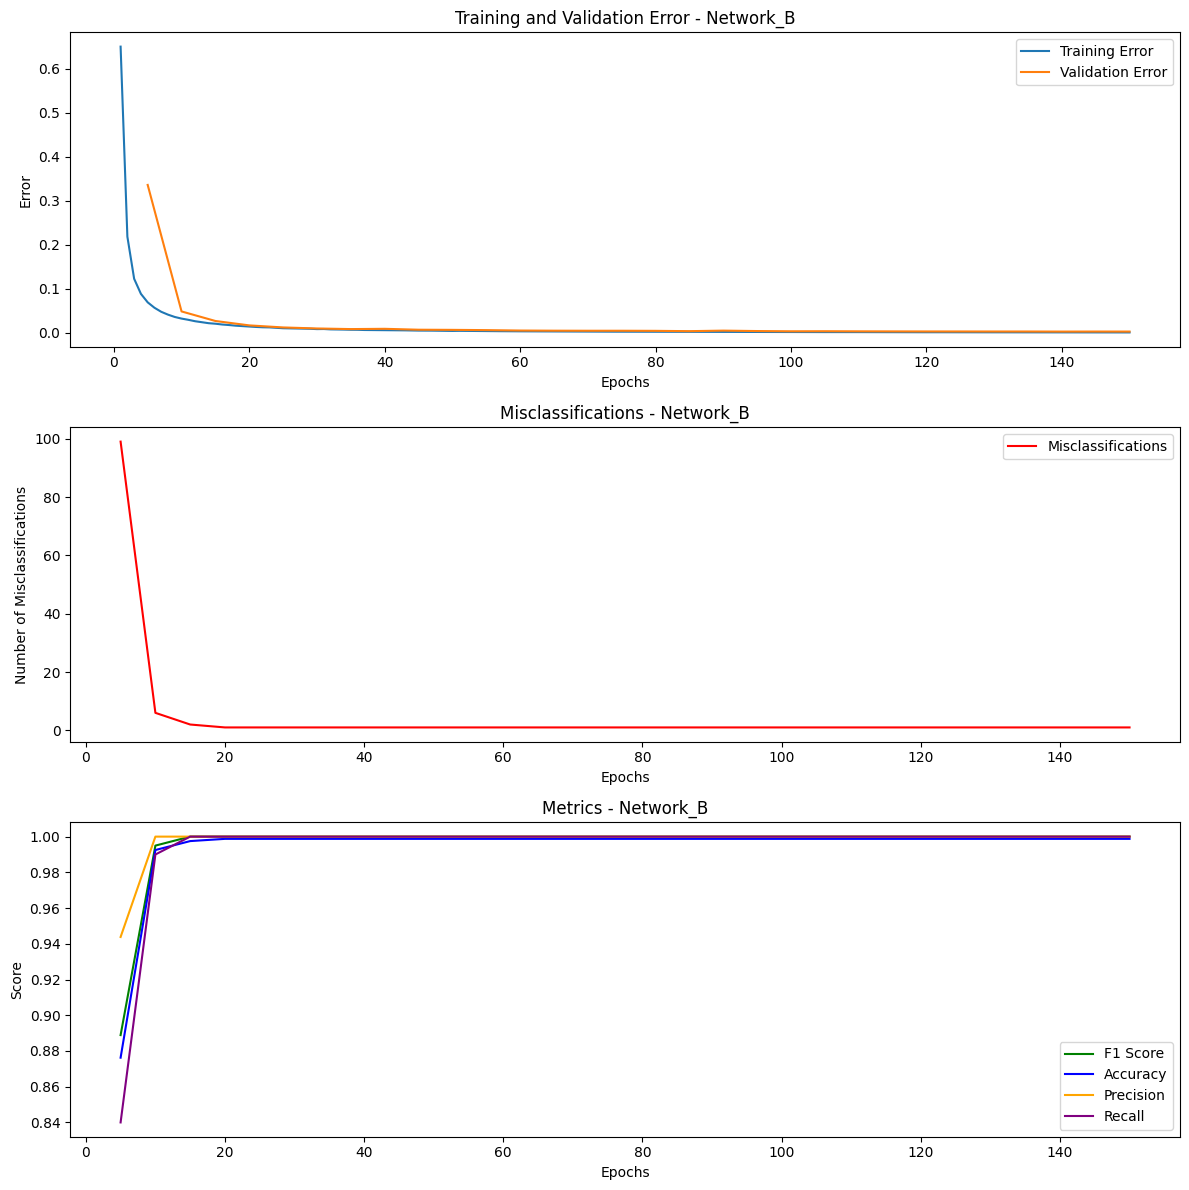

In [3]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt

# Load dataset
base_path = '/Users/annamariebenzon/Documents/PhD in AI/AI 201/Assignments/AI201_PA3_ANN_Data'
data_path = os.path.join(base_path, 'data.csv')
data_labels_path = os.path.join(base_path, 'data_labels.csv')

data = np.genfromtxt(data_path, delimiter=',')
data_labels = np.genfromtxt(data_labels_path, delimiter=',')

# Normalize input data
min_vals = np.min(data, axis=0)
max_vals = np.max(data, axis=0)
data = (data - min_vals) / (max_vals - min_vals)

# Balance dataset using an interpolation-based approach similar to SMOTE
unique_classes, class_counts = np.unique(data_labels, return_counts=True)
max_count = max(class_counts)
data_balanced = []
data_labels_balanced = []

for cls, count in zip(unique_classes, class_counts):
    class_data = data[data_labels == cls]
    class_labels = data_labels[data_labels == cls]
    num_samples_needed = max_count - count
    if num_samples_needed > 0:
        indices = np.random.choice(class_data.shape[0], num_samples_needed, replace=True)
        synthetic_samples = []
        for i in range(num_samples_needed):
            # Randomly select two samples to interpolate between
            sample_1, sample_2 = class_data[np.random.choice(class_data.shape[0], 2, replace=False)]
            # Generate synthetic sample through linear interpolation
            alpha = np.random.uniform(0, 1)
            synthetic_sample = alpha * sample_1 + (1 - alpha) * sample_2
            synthetic_samples.append(synthetic_sample)
        synthetic_samples = np.array(synthetic_samples)
        data_balanced.append(np.vstack((class_data, synthetic_samples)))
        data_labels_balanced.append(np.hstack((class_labels, np.full(num_samples_needed, cls))))
    else:
        data_balanced.append(class_data)
        data_labels_balanced.append(class_labels)

data_balanced = np.vstack(data_balanced)
data_labels_balanced = np.hstack(data_labels_balanced)

# Split into training and validation sets
np.random.seed(42)
indices = np.arange(data_balanced.shape[0])
np.random.shuffle(indices)

split_idx = data_balanced.shape[0] - 800
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

X_train = data_balanced[train_indices]
y_train = data_labels_balanced[train_indices]
X_val = data_balanced[val_indices]
y_val = data_labels_balanced[val_indices]

# One-hot encode labels
y_train_encoded = np.eye(8)[y_train.astype(int) - 1]
y_val_encoded = np.eye(8)[y_val.astype(int) - 1]

# Save the balanced training and validation sets
np.savetxt(os.path.join(base_path, 'training_set.csv'), X_train, delimiter=',')
np.savetxt(os.path.join(base_path, 'training_labels.csv'), y_train, delimiter=',')
np.savetxt(os.path.join(base_path, 'validation_set.csv'), X_val, delimiter=',')
np.savetxt(os.path.join(base_path, 'validation_labels.csv'), y_val, delimiter=',')

# Parameters
input_nodes = 354
hidden_nodes = [128, 64]  # Two hidden layers per instructions
output_nodes = 8
initial_learning_rate = 0.001
alpha = 0.9  # Momentum

# User inputs
mini_batch_size = int(input('Enter mini-batch size (default is 8): ') or 8)
hidden_activation_name_1 = input('Enter hidden activation function for first hidden layer (tanh, leaky_relu, logistic): ') or 'tanh'
hidden_activation_name_2 = input('Enter hidden activation function for second hidden layer (tanh, leaky_relu, logistic): ') or 'tanh'
load_weights = input('Do you want to load pre-trained weights? (yes/no): ').strip().lower() == 'yes'

# Activation functions
activation_functions = {
    'tanh': lambda x: 1.716 * np.tanh((2/3) * x),
    'tanh_derivative': lambda x: 1.716 * (2/3) * (1 - np.tanh((2/3) * x) ** 2),
    'logistic': lambda x: 2.0 / (1 + np.exp(-x)),
    'logistic_derivative': lambda x: (2.0 * np.exp(-x)) / (1 + np.exp(-x)) ** 2,
    'leaky_relu': lambda x: np.where(x > 0, x, 0.01 * x),
    'leaky_relu_derivative': lambda x: np.where(x > 0, 1, 0.01)
}

def train_network(hidden_activation_names, network_name):
    # Set activation functions for each layer
    hidden_activation_1 = activation_functions[hidden_activation_names[0]]
    hidden_activation_1_derivative = activation_functions[f'{hidden_activation_names[0]}_derivative']
    hidden_activation_2 = activation_functions[hidden_activation_names[1]]
    hidden_activation_2_derivative = activation_functions[f'{hidden_activation_names[1]}_derivative']
    output_activation = activation_functions['logistic']
    output_activation_derivative = activation_functions['logistic_derivative']

    # Initialize weights with Xavier Initialization
    if load_weights:
        weights_1 = np.loadtxt(os.path.join(base_path, f'weights_1_{network_name}.csv'), delimiter=',')
        weights_2 = np.loadtxt(os.path.join(base_path, f'weights_2_{network_name}.csv'), delimiter=',')
        weights_out = np.loadtxt(os.path.join(base_path, f'weights_out_{network_name}.csv'), delimiter=',')
        bias_1 = np.loadtxt(os.path.join(base_path, f'bias_1_{network_name}.csv'), delimiter=',').reshape(1, -1)
        bias_2 = np.loadtxt(os.path.join(base_path, f'bias_2_{network_name}.csv'), delimiter=',').reshape(1, -1)
        bias_out = np.loadtxt(os.path.join(base_path, f'bias_out_{network_name}.csv'), delimiter=',').reshape(1, -1)
    else:
        weights_1 = np.random.randn(input_nodes, hidden_nodes[0]) * np.sqrt(2 / input_nodes)
        weights_2 = np.random.randn(hidden_nodes[0], hidden_nodes[1]) * np.sqrt(2 / hidden_nodes[0])
        weights_out = np.random.randn(hidden_nodes[1], output_nodes) * np.sqrt(2 / hidden_nodes[1])

        bias_1 = np.zeros((1, hidden_nodes[0]))
        bias_2 = np.zeros((1, hidden_nodes[1]))
        bias_out = np.zeros((1, output_nodes))

    momentum_1 = np.zeros_like(weights_1)
    momentum_2 = np.zeros_like(weights_2)
    momentum_out = np.zeros_like(weights_out)

    # Training process
    num_epochs = 150
    training_errors = []
    validation_errors = []
    misclassifications = []
    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    # CSV files to save errors and metrics
    training_error_file = os.path.join(base_path, f'training_errors_{network_name}.csv')
    validation_error_file = os.path.join(base_path, f'validation_errors_{network_name}.csv')
    with open(training_error_file, 'w') as train_file, open(validation_error_file, 'w') as val_file:
        train_writer = csv.writer(train_file)
        val_writer = csv.writer(val_file)
        train_writer.writerow(['Epoch', 'Training_Error'])
        val_writer.writerow(['Epoch', 'Validation_Error', 'Misclassifications'])

        for epoch in range(num_epochs):
            # Shuffle training data
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train_encoded[indices]

            epoch_error = 0
            for i in range(0, X_train.shape[0], mini_batch_size):
                X_batch = X_train_shuffled[i:i + mini_batch_size]
                y_batch = y_train_shuffled[i:i + mini_batch_size]

                # Forward propagation
                hidden_input_1 = np.dot(X_batch, weights_1) + bias_1
                hidden_output_1 = hidden_activation_1(hidden_input_1)

                hidden_input_2 = np.dot(hidden_output_1, weights_2) + bias_2
                hidden_output_2 = hidden_activation_2(hidden_input_2)

                final_input = np.dot(hidden_output_2, weights_out) + bias_out
                final_output = output_activation(final_input)

                # Error calculation
                error = y_batch - final_output
                epoch_error += np.sum(error ** 2)

                # Backpropagation
                delta_out = error * output_activation_derivative(final_input)
                delta_hidden_2 = np.dot(delta_out, weights_out.T) * hidden_activation_2_derivative(hidden_input_2)
                delta_hidden_1 = np.dot(delta_hidden_2, weights_2.T) * hidden_activation_1_derivative(hidden_input_1)

                # Weight updates with momentum
                gradient_out = np.dot(hidden_output_2.T, delta_out)
                gradient_2 = np.dot(hidden_output_1.T, delta_hidden_2)
                gradient_1 = np.dot(X_batch.T, delta_hidden_1)

                momentum_out = alpha * momentum_out + initial_learning_rate * gradient_out
                momentum_2 = alpha * momentum_2 + initial_learning_rate * gradient_2
                momentum_1 = alpha * momentum_1 + initial_learning_rate * gradient_1

                weights_out += momentum_out
                weights_2 += momentum_2
                weights_1 += momentum_1

                # Update biases
                bias_out += initial_learning_rate * np.sum(delta_out, axis=0, keepdims=True)
                bias_2 += initial_learning_rate * np.sum(delta_hidden_2, axis=0, keepdims=True)
                bias_1 += initial_learning_rate * np.sum(delta_hidden_1, axis=0, keepdims=True)

            # Record training error
            training_errors.append(epoch_error / X_train.shape[0])
            train_writer.writerow([epoch + 1, epoch_error / X_train.shape[0]])

            # Validation error and misclassifications every 5 epochs
            if epoch % 5 == 0:
                hidden_output_1_val = hidden_activation_1(np.dot(X_val, weights_1) + bias_1)
                hidden_output_2_val = hidden_activation_2(np.dot(hidden_output_1_val, weights_2) + bias_2)
                final_output_val = output_activation(np.dot(hidden_output_2_val, weights_out) + bias_out)
                val_error = np.sum((y_val_encoded - final_output_val) ** 2)
                validation_errors.append(val_error / X_val.shape[0])

                # Calculate misclassifications
                predicted_classes = np.argmax(final_output_val, axis=1)
                true_classes = np.argmax(y_val_encoded, axis=1)
                misclassifications.append(np.sum(predicted_classes != true_classes))

                # Calculate metrics
                tp = np.sum((predicted_classes == true_classes) & (true_classes == 1))
                precision = tp / (np.sum(predicted_classes == 1) + 1e-10)
                recall = tp / (np.sum(true_classes == 1) + 1e-10)
                f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
                accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)

                f1_scores.append(f1)
                accuracy_scores.append(accuracy)
                precision_scores.append(precision)
                recall_scores.append(recall)

                # Save validation error and misclassifications
                val_writer.writerow([epoch + 1, val_error / X_val.shape[0], np.sum(predicted_classes != true_classes)])

    # Save weights
    np.savetxt(os.path.join(base_path, f'weights_1_{network_name}.csv'), weights_1, delimiter=',')
    np.savetxt(os.path.join(base_path, f'weights_2_{network_name}.csv'), weights_2, delimiter=',')
    np.savetxt(os.path.join(base_path, f'weights_out_{network_name}.csv'), weights_out, delimiter=',')
    np.savetxt(os.path.join(base_path, f'bias_1_{network_name}.csv'), bias_1, delimiter=',')
    np.savetxt(os.path.join(base_path, f'bias_2_{network_name}.csv'), bias_2, delimiter=',')
    np.savetxt(os.path.join(base_path, f'bias_out_{network_name}.csv'), bias_out, delimiter=',')

    # Plot learning curves for the network
    plt.figure(figsize=(12, 12))

    # Plot Training and Validation Error
    plt.subplot(3, 1, 1)
    plt.plot(range(1, num_epochs + 1), training_errors, label='Training Error')
    plt.plot(range(5, num_epochs + 1, 5), validation_errors, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f'Training and Validation Error - {network_name}')

    # Plot Misclassifications
    plt.subplot(3, 1, 2)
    plt.plot(range(5, num_epochs + 1, 5), misclassifications, label='Misclassifications', color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Number of Misclassifications')
    plt.legend()
    plt.title(f'Misclassifications - {network_name}')

    # Plot F1 Score, Accuracy, Precision, Recall
    plt.subplot(3, 1, 3)
    plt.plot(range(5, num_epochs + 1, 5), f1_scores, label='F1 Score', color='g')
    plt.plot(range(5, num_epochs + 1, 5), accuracy_scores, label='Accuracy', color='b')
    plt.plot(range(5, num_epochs + 1, 5), precision_scores, label='Precision', color='orange')
    plt.plot(range(5, num_epochs + 1, 5), recall_scores, label='Recall', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.title(f'Metrics - {network_name}')
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(os.path.join(base_path, f'learning_curves_{network_name}.png'))
    plt.show()

# Train Network A (Tanh-Tanh-Logistic)
train_network([hidden_activation_name_1, hidden_activation_name_2], 'Network_A')

# Train Network B (LeakyReLU-LeakyReLU-Logistic)
train_network(['leaky_relu', 'leaky_relu'], 'Network_B')

# Calculate confusion matrix and performance metrics for validation set
def evaluate_network(network_name, hidden_activation_names):
    # Load weights
    weights_1 = np.loadtxt(os.path.join(base_path, f'weights_1_{network_name}.csv'), delimiter=',')
    weights_2 = np.loadtxt(os.path.join(base_path, f'weights_2_{network_name}.csv'), delimiter=',')
    weights_out = np.loadtxt(os.path.join(base_path, f'weights_out_{network_name}.csv'), delimiter=',')
    bias_1 = np.loadtxt(os.path.join(base_path, f'bias_1_{network_name}.csv'), delimiter=',').reshape(1, -1)
    bias_2 = np.loadtxt(os.path.join(base_path, f'bias_2_{network_name}.csv'), delimiter=',').reshape(1, -1)
    bias_out = np.loadtxt(os.path.join(base_path, f'bias_out_{network_name}.csv'), delimiter=',').reshape(1, -1)

    # Set activation functions for evaluation
    hidden_activation_1 = activation_functions[hidden_activation_names[0]]
    hidden_activation_2 = activation_functions[hidden_activation_names[1]]
    output_activation = activation_functions['logistic']

    # Forward pass through the network
    hidden_output_1_val = hidden_activation_1(np.dot(X_val, weights_1) + bias_1)
    hidden_output_2_val = hidden_activation_2(np.dot(hidden_output_1_val, weights_2) + bias_2)
    final_output_val = output_activation(np.dot(hidden_output_2_val, weights_out) + bias_out)

    # Convert network outputs to class labels
    predicted_classes = np.argmax(final_output_val, axis=1) + 1
    true_classes = np.argmax(y_val_encoded, axis=1) + 1

    # Calculate confusion matrix and performance metrics manually
    cm = np.zeros((8, 8), dtype=int)
    for t, p in zip(true_classes, predicted_classes):
        cm[t-1, p-1] += 1

    acc = np.trace(cm) / np.sum(cm)
    prec = np.sum([cm[i, i] / (np.sum(cm[:, i]) + 1e-10) for i in range(8)]) / 8
    rec = np.sum([cm[i, i] / (np.sum(cm[i, :]) + 1e-10) for i in range(8)]) / 8
    f1 = 2 * (prec * rec) / (prec + rec + 1e-10)
    mcc_num = (np.sum([cm[i, i] for i in range(8)]) * np.sum([cm[i, i] for i in range(8)])) - (np.sum([np.sum(cm[:, i]) * np.sum(cm[i, :]) for i in range(8)]))
    mcc_den = np.sqrt((np.sum([np.sum(cm[:, i]) for i in range(8)]) * np.sum([np.sum(cm[i, :]) for i in range(8)])))
    mcc = mcc_num / (mcc_den + 1e-10)

    # Save confusion matrix and metrics
    np.savetxt(os.path.join(base_path, f'confusion_matrix_{network_name}.csv'), cm, delimiter=',')
    with open(os.path.join(base_path, f'metrics_{network_name}.csv'), 'w') as metrics_file:
        metrics_writer = csv.writer(metrics_file)
        metrics_writer.writerow(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC'])
        metrics_writer.writerow([acc, prec, rec, f1, mcc])

# Evaluate Network A
evaluate_network('Network_A', [hidden_activation_name_1, hidden_activation_name_2])

# Evaluate Network B
evaluate_network('Network_B', ['leaky_relu', 'leaky_relu'])

# Load previously trained weights and use them to predict labels for the test set
def predict_test_set(network_name, test_data_path, hidden_activation_names, output_file):
    # Load weights
    weights_1 = np.loadtxt(os.path.join(base_path, f'weights_1_{network_name}.csv'), delimiter=',')
    weights_2 = np.loadtxt(os.path.join(base_path, f'weights_2_{network_name}.csv'), delimiter=',')
    weights_out = np.loadtxt(os.path.join(base_path, f'weights_out_{network_name}.csv'), delimiter=',')
    bias_1 = np.loadtxt(os.path.join(base_path, f'bias_1_{network_name}.csv'), delimiter=',').reshape(1, -1)
    bias_2 = np.loadtxt(os.path.join(base_path, f'bias_2_{network_name}.csv'), delimiter=',').reshape(1, -1)
    bias_out = np.loadtxt(os.path.join(base_path, f'bias_out_{network_name}.csv'), delimiter=',').reshape(1, -1)

    # Load test data
    X_test = np.genfromtxt(test_data_path, delimiter=',')

    # Normalize test data
    X_test = (X_test - min_vals) / (max_vals - min_vals)

    # Set activation functions for prediction
    hidden_activation_1 = activation_functions[hidden_activation_names[0]]
    hidden_activation_2 = activation_functions[hidden_activation_names[1]]
    output_activation = activation_functions['logistic']

    # Forward pass through the network
    hidden_output_1_test = hidden_activation_1(np.dot(X_test, weights_1) + bias_1)
    hidden_output_2_test = hidden_activation_2(np.dot(hidden_output_1_test, weights_2) + bias_2)
    final_output_test = output_activation(np.dot(hidden_output_2_test, weights_out) + bias_out)

    # Convert network outputs to class labels
    predicted_test_labels = np.argmax(final_output_test, axis=1) + 1

    # Save predictions to CSV file
    np.savetxt(output_file, predicted_test_labels, delimiter=',', fmt='%d')

# Predict labels for the test set using trained Network A
predict_test_set('Network_A', os.path.join(base_path, 'test_set.csv'), [hidden_activation_name_1, hidden_activation_name_2], os.path.join(base_path, 'predictions_for_test_tanh.csv'))

# Predict labels for the test set using trained Network B
predict_test_set('Network_B', os.path.join(base_path, 'test_set.csv'), ['leaky_relu', 'leaky_relu'], os.path.join(base_path, 'predictions_for_test_leakyrelu.csv'))
